# SARDI Capture Evaluation

First a qualitative comparison of rgb image, averaged 'ground truth', the original image, and the classified result.

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import cv2
import os

from spectral import *

from os.path import exists

from sklearn.decomposition import PCA

from skimage.segmentation import slic, mark_boundaries

from sklearn.cluster import KMeans

List out all files in directory to process for easier use, recall, every second capture is aligned the same starting at capture 2 (1 indexed)

In [ ]:
path = "processed-data/sardi-capture/capture-3/reflectance/2023_02_28/"

dir_cont = os.listdir(path)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]

data_cubes = sorted(data_cubes)

cubes = []

for i in range(len(data_cubes)):    
    # capture every second item
    if i%2 == 1:
        cubes.append(data_cubes[i])

print(cubes)

['2023_03_27-23_57_45.nc', '2023_03_28-00_16_45.nc', '2023_03_28-00_18_30.nc', '2023_03_28-00_21_07.nc', '2023_03_28-00_22_43.nc', '2023_03_28-00_50_41.nc', '2023_03_28-01_03_41.nc', '2023_03_28-01_07_00.nc', '2023_03_28-01_15_29.nc', '2023_03_28-01_17_56.nc', '2023_03_28-01_22_15.nc', '2023_03_28-01_45_56.nc', '2023_03_28-01_48_52.nc', '2023_03_28-01_51_30.nc', '2023_03_28-01_54_05.nc', '2023_03_28-01_56_37.nc', '2023_03_28-01_58_54.nc', '2023_03_28-02_16_51.nc', '2023_03_28-02_19_32.nc', '2023_03_28-02_21_43.nc', '2023_03_28-02_23_58.nc', '2023_03_28-02_26_42.nc', '2023_03_28-02_29_35.nc', '2023_03_28-02_33_10.nc', '2023_03_28-02_35_15.nc']


In [ ]:
iteration='1'

## Loading Data

Here I'm going to use my pre-processed files containing reflectance values.

Given the fact that OpenHSI saves them in NetCDF format I'm using the `netCDF4` library to load them.

I'm also transposing the data array into a more comment layout.

In [ ]:
fn = path + iteration + ".nc"
fn_rad = fn.replace('reflectance','radiance')

gnd_t_fn = "right-pipe-gt.pkl"

In [ ]:
# Load data
ds = nc.Dataset(fn)
ds_rad = nc.Dataset(fn_rad)

In [ ]:
# extract the datacube from the dataset
dc = np.array(ds['datacube'])

In [ ]:
# Data needs to be x, y, bands instead of bands, x, y.
data = dc.transpose(1,2,0)

In [ ]:
# limit data to area of interest, so that gt lines up
# these values are taken from the gt-average notebook processing
# the x value cuts off the noise from the camera at the bottom of the image
# the y values center the pipe among all of the images
data = data[:430,:930, :]

In [ ]:
# transform into a line of pixels for PCA
X = data.copy().reshape(data.shape[0]*data.shape[1],data.shape[2])

In [ ]:
print(X.shape)

(410400, 528)


In [ ]:
# Load ground truth
with open(gnd_t_fn, 'rb') as out_file:
    ground_truth = pickle.load(out_file)

In [ ]:
y = ground_truth.copy().reshape(ground_truth.shape[0]*ground_truth.shape[1])  

In [ ]:
print(y.shape)

(399900,)


## Useful Functions

In [ ]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube'])
    data = loc_dc.transpose(1,2,0)
    data = data[:430,:930, :] # limit to area we are interested in
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])
    loc_image = np.zeros((data.shape[0],data.shape[1],3), np.uint8)
    
    # This is not working, it could be a ram issue
    # input_tens = torch.tensor(data, dtype=torch.float32, device="cpu")
    # hyres = hyde.HyRes()
    # dn_data = hyres(input_tens).numpy()
    dn_data = data

    loc_red_wavelength = 620
    loc_green_wavelength = 560
    loc_blue_wavelength = 460

    loc_red_layer = dn_data[:,:,np.argmin(np.abs(loc_binned_wavelengths-loc_red_wavelength))]  
    loc_green_layer = dn_data[:,:,np.argmin(np.abs(loc_binned_wavelengths-loc_green_wavelength))] 
    loc_blue_layer = dn_data[:,:,np.argmin(np.abs(loc_binned_wavelengths-loc_blue_wavelength))]
    
    loc_image[:,:,0] = loc_red_layer
    loc_image[:,:,1] = loc_green_layer
    loc_image[:,:,2] = loc_blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    loc_vmax = np.nanpercentile(loc_image, 98)
    loc_vmin = np.nanpercentile(loc_image, 2)
    loc_image = ((loc_image.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
    loc_image = np.minimum(np.maximum(loc_image, 0), 1)

    loc_image *= 255
    loc_image = loc_image.astype(np.uint8)
    
    return loc_image

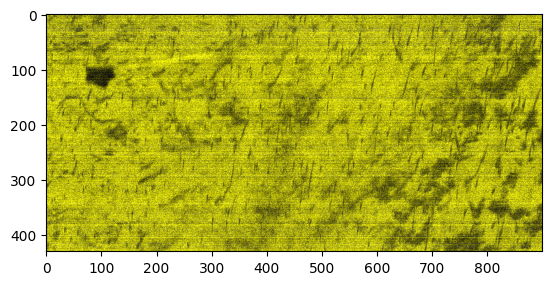

In [ ]:
plt.imshow(process_into_rgb(ds_rad))

## Reducing Dimentionality

I'm just going to perform a simple PCA here to reduce the dimentionality of the image. I should be able to reduce the number of bands without distorting the spacial data and then apply the segmentation later to the original data, or an RGB representation, if I wish.

The first section of code is redundant and only there for sanity checking and illustrative purposes

### PCA

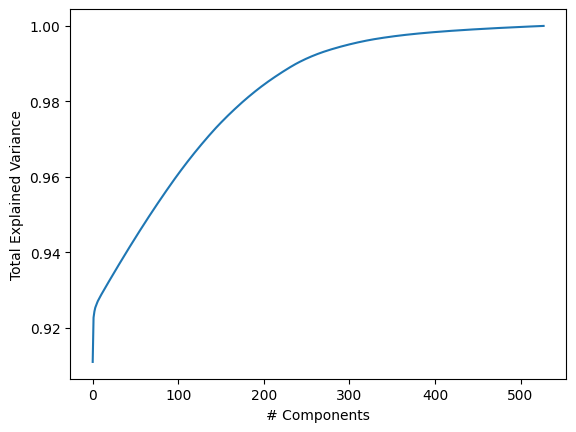

In [ ]:
run = True
if run:
    pca = PCA()

    # fit my data, and transform
    pcX = pca.fit_transform(X)

    # graph the variance of each component (should give a good idea about the number of components to use).
    ev = pca.explained_variance_ratio_
    cumulativeVar = np.cumsum(ev)
    
    plt.plot(cumulativeVar)
    plt.xlabel('# Components')
    plt.ylabel('Total Explained Variance')
    plt.savefig('evaluations/sardi/'+iteration+'_pca_elbow.png')
    plt.show()

Now to actually perform the PCA.

In [ ]:
# pick number of components that seems reasonable.
nComp = 20 # between 85-90% of the variance
pca = PCA(n_components=nComp)
pca.fit(X)
pcX = pca.transform(X)

In [ ]:
# check the new dimensions
print(pcX.shape)

(410400, 20)


In [ ]:
# reformat the image into the original shape
image_pca = pcX.reshape(data.shape[0], data.shape[1], pcX.shape[1])
print(image_pca.shape)

(456, 900, 20)


In [ ]:
# let's have a look at the reduced image, if using 3 components
if image_pca.shape[2] == 3:
    plt.imshow(image_pca, 'gray')

## K-means elbow method to determine optimal n_clusters

/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

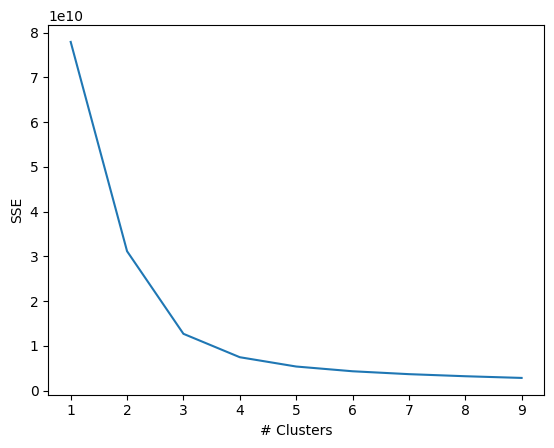

In [ ]:
# Only running this once to prove a point, it takes too long.
run = False
if run:
    inertia = {}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k).fit(pcX)
        inertia[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(inertia.keys()), list(inertia.values()))
    plt.xlabel("# Clusters")
    plt.ylabel("SSE")
    plt.savefig('evaluations/sardi/'+iteration+'_k-means_elbow.png')
    plt.show()

## Classification

In [ ]:
# create our classifier
k_means = KMeans(n_clusters=5) # based on elbow method above, going to stick to this number

In [ ]:
# classify
k_fit = k_means.fit(pcX)

/home/solomon/.pyenv/versions/3.8.16/envs/openhsi/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# capture clusers and labels
x_labels = k_means.labels_
x_cluster = x_labels.reshape(image_pca[:, :, 0].shape)

In [ ]:
plt.imshow(x_cluster)
plt.imsave('evaluations/sardi/'+iteration+'_classification.png', x_cluster)

In [ ]:
def change_value(img, v_from, v_to):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == v_from:
                img[i,j] = v_to
    return img

classified_waste = x_cluster.copy()
                
classified_waste = change_value(classified_waste, 0, 0)
classified_waste = change_value(classified_waste, 1, 1)
classified_waste = change_value(classified_waste, 2, 0)
classified_waste = change_value(classified_waste, 3, 0)
classified_waste = change_value(classified_waste, 4, 0)
# classified_waste = change_value(classified_waste, 5, 0)
            
plt.imshow(classified_waste)

In [ ]:
plt.imsave('evaluations/sardi/'+iteration+'_class_waste.png', classified_waste)

In [ ]:
final = [np.full(x_cluster.shape,0),classified_waste,classified_waste]
final = np.array(final).transpose(1,2,0)*255
final = final.astype(np.uint8)
plt.imshow(final)
plt.imsave('evaluations/sardi/'+iteration+'_class_final.png', final)

## Blend original and classification

In [ ]:
original = process_into_rgb(ds_rad)
original = original[:430,:930, :]
plt.imshow(original)
plt.imsave('evaluations/sardi/'+iteration+'_original.png', original)

In [ ]:
print(original.shape)
print(original.dtype)
print(final.shape)
print(final.dtype)

In [ ]:
blended = cv2.addWeighted(final, 0.6, original, 0.6, 0)
plt.imshow(blended)
plt.imsave('evaluations/sardi/'+iteration+'_blended.png', blended)

## Compare to ground truth and RGB image

In [ ]:
plt.imshow(ground_truth)

In [ ]:
plt.imshow(cv2.imread('right-pipe-rgb.jpg'))

## Matched Filter

In [ ]:
# let the user choose a pixel to mach

img_copy = blended.copy()
pixel = (0,0)

def on_click(event,x,y,flags,params):
    global pixel
    global img_copy

    if event == cv2.EVENT_LBUTTONDOWN:
        img_copy = blended.copy()
        pixel = data[y,x]
        cv2.circle(img_copy,(x,y),5,(127,255,127),1)
        cv2.circle(img_copy,(x,y),1,(255,127,127),1)
    
cv2.namedWindow('Image')
cv2.setMouseCallback('Image', on_click)

while True:
    cv2.imshow('Image',img_copy)

    k = cv2.waitKey(1)

    # jump out of loop and close all windows with ESC
    if k == 27:
        break

cv2.destroyAllWindows()

In [ ]:
# let the user select an area to average and match

# Select ROI
r = cv2.selectROI("select roi", blended)

# close the window
cv2.destroyAllWindows()

# Crop hsi image
cropped = data[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2]),:]

sample_img = blended.copy()
#                         src, startpoint, endpoint, colour, thickness
sample_img = cv2.rectangle(sample_img, (int(r[0]),int(r[1])), (int(r[0]+r[2]),int(r[1]+r[3])), (27,27,27), 2)

reshaped = cropped.reshape(cropped.shape[0]*cropped.shape[1], cropped.shape[2])

# take mean of sample area
pixel = np.mean(reshaped,0)

In [ ]:
# filter the image and match on the chosen pixel
matched = matched_filter(data, pixel)

In [ ]:
# view the matches from the single pixel
matched_img = 1 * (matched > 0.5)
v = imshow(matched_img)

In [ ]:
plt.imsave('evaluations/sardi/'+iteration+'_mf.png', matched_img)

## Compare to ground truth and RGB image

In [ ]:
plt.imshow(ground_truth)

In [ ]:
plt.imshow(cv2.imread('right-pipe-rgb.jpg'))